In [1]:
#| default_exp evaluating

# Evaluation
For each task of segmenting, matching, and sequencing, we specify an abstract class that defines the interface for implementations that compare the results of the algorithm to the ground truth. 

## Segmenter Evaluator

In [2]:
#| code-summary: specify an abstract base class for implementing an evaluator of Segmenter concrete classes.

#| export
from abc import ABC, abstractmethod
from typing import List, Dict

class SegmenterEvaluator(ABC):

    """
    Abstract base class for implementing an evaluator of Segmenter concrete classes. To create a custom SegmenterEvaluator, inherit from this class and override the compare method.
    """

    @abstractmethod
    def __call__(self, response_text: str, generated_units: List[Dict[str, object]], reference_units: List[Dict[str, object]]) -> float:
        """
        Identifies the sequence of target items generated in the input text.

        Parameters:
            response_text (str): The response text.
            generated_units List[Dict[str, object]]: The sequence of generated units.
            reference_units List[Dict[str, object]]: The sequence of reference units.

            Each unit is a dictionary with keys "text" and "spans":
            The "text" key corresponds to the text representation, 
            The "spans" key corresponds to a list of character-level start and end indices (tuples) in the reference text.

        Returns:
            float: The evaluation score.
        """
        pass

### Jaccard Score
Defined as the size of the intersection divided by the size of the union of two label sets. A value of 1 when the two sets are identical, and 0 when they are disjoint.

In [3]:
#| code-summary: specify an evaluator of Segmenter concrete classes that computes the Jaccard score across spans

#| export
from sklearn.metrics import jaccard_score
import numpy as np

class JaccardScoreSegmenterEvaluator(SegmenterEvaluator):

    def __call__(self, response_text: str, 
                 generated_units: List[Dict[str, object]], 
                 comparison_units: List[Dict[str, object]]) -> float:
        
        gen_labels = self._assign_labels(response_text, generated_units)
        comp_labels = self._assign_labels(response_text, comparison_units)
        return float(jaccard_score(comp_labels, gen_labels, average='samples'))

    def _assign_labels(self, response_text: str, units) -> List[List[int]]:

        labels = np.zeros((len(units), len(response_text)), dtype=int)
        for i, unit in enumerate(units):
            for span in unit["spans"]:
                start, end = span
                labels[i, start:end] = 1

        return labels.tolist()

In [4]:
#| code-summary: demonstrate the use of the JaccardScoreSegmenterEvaluator class.

from response_sequencer.datasets import SensesDataset
from response_sequencer.sequencing import BaselineSequencer
from response_sequencer.demo import flatten_matches
import os

section_tag = 'base' # unique identifier for this variation of notebook parameters
output_dir = '../../data/'

dataset = SensesDataset(
    os.path.join(output_dir, f'{section_tag}_senses.h5'), 
    os.path.join(output_dir, f'{section_tag}_sense_pool.txt'))
sequencer = BaselineSequencer()

trial_index = 0
trial = dataset.__getitem__(trial_index)

response_text = trial["response_transcript"]
matched_target_items, reference_units = flatten_matches(
        trial['target_items'], trial['response_units'], trial['matches'])
result = sequencer(response_text, matched_target_items)

matched_target_items, generated_units = flatten_matches(matched_target_items, result['response_units'], result['matches'])

typical_result = JaccardScoreSegmenterEvaluator()(
    response_text, generated_units, reference_units)

perfect_result = JaccardScoreSegmenterEvaluator()(
    response_text, reference_units, reference_units)

typical_result, perfect_result

(0.8177843654941555, 1.0)

## Matcher Evaluator

In [5]:
#| code-summary: specify an abstract base class for implementing an evaluator of Matcher concrete classes.

#| export

class MatcherEvaluator(ABC):

    """
    Abstract base class for implementing an evaluator of Matcher concrete classes. To create a custom MatcherEvaluator, inherit from this class and override the compare method.
    """

    @abstractmethod
    def __call__(
        self, response_text: str, reference_units: List[Dict[str, object]], generated_units: List[Dict[str, object]], 
        reference_matching: List[List[bool]], generated_matching: List[List[bool]]) -> float:
        """
        Identifies the sequence of target items generated in the input text.

        Parameters:
            response_text (str): The response text.
            reference_units (List[Dict[str, object]]): List of reference response units
            generated_units (List[Dict[str, object]]): List of generated response_units

                Each reference and generated unit is a dictionary with keys "text" and "spans":
                The "text" key corresponds to the text representation, 
                The "spans" key corresponds to a list of character-level start and end indices (tuples) 
                in the input text.

            reference_matching (List[List[bool]]): matchings between target items and reference units
            generated_matching (List[List[bool]]): matchings between target items and generated units

            matchings are 2-D boolean numpy arrays of shape (len(target_items), len(units)) containing True 
            if the target item matches the reference or generated unit at the corresponding index.

        Returns:
            float: The evaluation score.
        """
        pass

### SegmentMatcherEvaluator

In [6]:
#| code-summary: specify an evaluator of Matcher concrete classes that compares matched segments using a SegmenterEvaluator

#|export
import numpy as np

class SegmentMatcherEvaluator(MatcherEvaluator):
    """
    Evaluates matchings by comparing for each target item the matched reference unit with the matched generated unit using a SegmenterEvaluator
    
    """

    def __init__(self, segmenter_evaluator: SegmenterEvaluator, only_matched: bool = False):
        """
        Parameters:
            segmenter_evaluator (SegmenterEvaluator): The SegmenterEvaluator to use for comparing the matched units
            only_matched (bool): If True, only target items with a matched reference unit are considered

            `segmenter_evaluator` should have a __call__ method with parameters (response_text, generated_units, reference_units) and return a float score
        """

        self.segmenter_evaluator = segmenter_evaluator
        self.only_matched = only_matched
        
    def __call__(
        self, response_text: str, reference_units: List[Dict[str, object]], 
        generated_units: List[Dict[str, object]], 
        reference_matching: List[str], generated_matching: List[str]) -> float:
        """
        Identifies the sequence of target items generated in the input text.

        Parameters:
            response_text (str): The response text.
            reference_units (List[Dict[str, object]]): List of reference response units
            generated_units (List[Dict[str, object]]): List of generated response_units

                Each reference and generated unit is a dictionary with keys "text" and "spans":
                The "text" key corresponds to the text representation, 
                The "spans" key corresponds to a list of character-level start and end indices (tuples) 
                in the input text.

            reference_matching (np.ndarray): matchings between target items and reference units
            generated_matching (np.ndarray): matchings between target items and generated units

            matchings are 2-D boolean numpy arrays of shape (len(target_items), len(units)) containing True 
            if the target item matches the reference or generated unit at the corresponding index.

        Returns:
            float: The evaluation score.
        """

        # represent matchings as arrays
        reference_matching = np.array(reference_matching)
        generated_matching = np.array(generated_matching)

        if self.only_matched:
            valid_targets = np.any(reference_matching, axis=1)
            reference_matching = reference_matching[valid_targets]
            generated_matching = generated_matching[valid_targets]
            
        reference_units = [reference_units[i] for i in np.argmax(reference_matching, axis=1)]
        generated_units = [generated_units[i] for i in np.argmax(generated_matching, axis=1)]

        return self.segmenter_evaluator(response_text, generated_units, reference_units)

In [7]:
#| code-summary: demonstrate the SegmentMatcherEvaluator with the JaccardScoreSegmenterEvaluator

trial_index = 0
trial = dataset.__getitem__(trial_index)
result = sequencer(trial['response_transcript'], trial['target_items'])
evaluator = SegmentMatcherEvaluator(JaccardScoreSegmenterEvaluator(), only_matched=True)

typical_result = evaluator(
    trial['response_transcript'], trial['response_units'], result['response_units'], 
    trial['matches'], result['matches'])

perfect_result = evaluator(
    trial['response_transcript'], trial['response_units'], trial['response_units'],
    trial['matches'], trial['matches'])

typical_result, perfect_result

(0.8177843654941555, 1.0)

### Levenshtein Distance

In [8]:
#| code-summary: specify an evaluator of Matcher concrete classes that compares the edit distance of generated and reference target item sequences

#|export
from edist.sed import standard_sed

class LevenshteinMatcherEvaluator(MatcherEvaluator):
    """
    Uses Levenshtein distance between extracted target item sequences to measure performance
    """

    def __init__(self,only_matched: bool = False):
        """
        Parameters:
            only_matched (bool): If True, only target items with a matched reference unit are considered
        """

        self.only_matched = only_matched
        
    def __call__(
        self, response_text: str, reference_units: List[Dict[str, object]], generated_units: List[Dict[str, object]], 
        reference_matching: List[List[bool]], generated_matching: List[List[bool]]) -> float:
        """
        Identifies the sequence of target items generated in the input text.

        Parameters:
            response_text (str): The response text.
            reference_units (List[Dict[str, object]]): List of reference response units
            generated_units (List[Dict[str, object]]): List of generated response_units

                Each reference and generated unit is a dictionary with keys "text" and "spans":
                The "text" key corresponds to the text representation, 
                The "spans" key corresponds to a list of character-level start and end indices (tuples) 
                in the input text.

            reference_matching (List[List[bool]]): matchings between target items and reference units
            generated_matching (List[List[bool]]): matchings between target items and generated units

            matchings are 2-D boolean numpy arrays of shape (len(target_items), len(units)) containing True 
            if the target item matches the reference or generated unit at the corresponding index.

        Returns:
            float: The evaluation score.
        """

        # represent matchings as arrays
        reference_matching = np.array(reference_matching)
        generated_matching = np.array(generated_matching)

        if self.only_matched:
            valid_targets = np.any(reference_matching, axis=1)
            reference_matching = reference_matching[valid_targets]
            generated_matching = generated_matching[valid_targets]

        reference_recalled_targets = np.any(reference_matching, axis=1)
        generated_recalled_targets = np.any(generated_matching, axis=1)

        reference_matching = reference_matching[reference_recalled_targets]
        generated_matching = generated_matching[generated_recalled_targets]

        reference_units = [reference_units[i] for i in np.argmax(reference_matching, axis=1)]
        generated_units = [generated_units[i] for i in np.argmax(generated_matching, axis=1)]

        reference_sequence = np.where(reference_recalled_targets)[0].tolist()
        generated_sequence = np.where(generated_recalled_targets)[0].tolist()

        paired_reference = list(zip(reference_sequence, reference_units))
        paired_generated = list(zip(generated_sequence, generated_units))

        sorted_reference = sorted(paired_reference, key=lambda x: self._span_based_ordering(x[1]))
        sorted_generated = sorted(paired_generated, key=lambda x: self._span_based_ordering(x[1]))

        sorted_reference = [x[0] for x in sorted_reference]
        sorted_generated = [x[0] for x in sorted_generated]

        # print(sorted_reference, sorted_generated, standard_sed(sorted_reference, sorted_generated))
        return standard_sed(sorted_reference, sorted_generated)

    
    def _span_based_ordering(self, matched_response_unit):
        return (matched_response_unit['spans'][0][0], matched_response_unit['spans'][-1][1])        

In [9]:
#| code-summary: demonstrate how the LevenshteinMatcherEvaluator can be used to evaluate the performance of the Sequencer

trial_index = 0
trial = dataset.__getitem__(trial_index)
result = sequencer(trial['response_transcript'], trial['target_items'])
evaluator = LevenshteinMatcherEvaluator()

typical_result = evaluator(
    trial['response_transcript'], trial['response_units'], result['response_units'], 
    trial['matches'], result['matches'])

perfect_result = evaluator(
    trial['response_transcript'], trial['response_units'], trial['response_units'],
    trial['matches'], trial['matches'])

typical_result, perfect_result

(6, 0)

## Dataset Generation

In [10]:
#| code-summary: specify a dataset generator that applies a Sequencer to a source dataset to generate a dataset mapping target items to response text

#| export
from torch.utils.data import Dataset
from response_sequencer.sequencing import Sequencer
from tqdm import tqdm
import json

class DatasetGenerator:
    """
    Generates a dataset of response text and target items by applying a Sequencer to a source dataset.
    """

    def __call__(self, dataset: Dataset, sequencer: Sequencer, out_path: str = "", samples: int = 0, random: bool = False):

        if samples == 0:
            samples = len(dataset)

        if random:
            indices = np.random.choice(len(dataset), size=samples, replace=False)
        else:
            indices = np.arange(samples)
        
        generated_dataset = []
        for i in tqdm(indices):
            batch = dataset[i]
            response_text = batch['response_transcript']
            if not response_text:
                continue

            target_items = batch['target_items']
            reference_units = batch['response_units']
            if not reference_units:
                continue
    
            reference_matching = batch['matches']
            result = sequencer(response_text, target_items)
            result['trial'] = int(i)

            generated_dataset.append(result)

        if out_path:
            with open(out_path, 'w') as f:
                json.dump(generated_dataset, f)
        else:
            return generated_dataset
    

In [11]:
#| code-summary: demonstrate how the DatasetGenerator can be used to generate a dataset of response text and target items

DatasetGenerator()(dataset, sequencer, out_path="../../data/generated_dataset.json", samples=5, random=True)

100%|██████████| 5/5 [00:00<00:00, 11.08it/s]


## Dataset Evaluation

In [12]:
#| code-summary: specify a dataset evaluator that compares the matched reference and generated units using a MatcherEvaluator

#| export
from torch.utils.data import Dataset
from response_sequencer.sequencing import Sequencer
from tqdm import tqdm

class DatasetEvaluator:
    """
    Evaluates matchings by comparing for each target item the matched reference unit with the matched generated unit using a SegmenterEvaluator
    
    """

    def __init__(self, reference_dataset: Dataset, comparison_dataset: Dataset):
        """
        Parameters:
            matcher_evaluator (MatcherEvaluator): The evaluator comparing the matched reference and generated units
        """

        self.reference_dataset = reference_dataset
        self.comparison_dataset = comparison_dataset

    def __call__(self, evaluator: MatcherEvaluator) -> List[float]:
        """
        Applies evaluation to a random sample of the dataset.

        Parameters:
            samples (int): The number of samples to evaluate. If 0, all samples are evaluated.

        Returns:
            List[float]: The evaluation scores.
        """

        scores = []
        for sample in self.comparison_dataset:

            batch = self.reference_dataset[sample['trial']]
            response_text = batch['response_transcript']
            if not response_text:
                continue

            target_items = batch['target_items']
            reference_units = batch['response_units']
            if not reference_units:
                continue
            reference_matching = batch['matches']

            generated_units = sample['response_units']
            generated_matching = sample['matches']

            scores.append(evaluator(
                response_text, reference_units, generated_units, reference_matching, generated_matching))

        return scores

In [13]:
#| code-summary: demonstrate how the DatasetEvaluator can be used to evaluate the performance of the Sequencer

generated_dataset = DatasetGenerator()(dataset, sequencer, samples=5, random=True)
dataset_evaluator = DatasetEvaluator(dataset,  generated_dataset)
scores = dataset_evaluator(LevenshteinMatcherEvaluator(only_matched=True))
print(np.mean(scores))

100%|██████████| 5/5 [00:00<00:00, 10.23it/s]

0.8


In [14]:
#| export

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

def visualize_confidence_interval(samples, confidence_level=0.95):
    # Calculate the sample mean and standard error of the mean
    sample_mean = np.mean(samples)
    sample_sem = stats.sem(samples)
    
    # Calculate the degrees of freedom
    degrees_of_freedom = len(samples) - 1
    
    # Calculate the t-critical value for the specified confidence level
    t_critical = stats.t.ppf((1 + confidence_level) / 2, degrees_of_freedom)
    
    # Calculate the margin of error
    margin_of_error = t_critical * sample_sem
    
    # Calculate the lower and upper bounds of the confidence interval
    lower_bound = sample_mean - margin_of_error
    upper_bound = sample_mean + margin_of_error

    print(f'Confidence Level: {confidence_level*100:.1f}%')
    print(f'Sample Mean: {sample_mean:.3f}')
    print(f'Lower Bound: {lower_bound:.3f}')
    print(f'Upper Bound: {upper_bound:.3f}')
    

    # Plot the confidence interval
    plt.figure(figsize=(8, 6))
    plt.axhline(y=sample_mean, color='blue', linestyle='-', label='Sample Mean')
    plt.axhline(y=lower_bound, color='red', linestyle='--', label='Lower Bound')
    plt.axhline(y=upper_bound, color='green', linestyle='--', label='Upper Bound')
    plt.fill_betweenx([lower_bound, upper_bound], 0, 1, color='gray', alpha=0.3, label='Confidence Interval')
    plt.legend(loc='upper right')
    plt.xlim(0, 1)
    plt.xlabel('Samples')
    plt.ylabel('Value')
    plt.title(f'{confidence_level*100:.1f}% Confidence Interval')
    plt.show()

Confidence Level: 95.0%
Sample Mean: 0.800
Lower Bound: -0.560
Upper Bound: 2.160


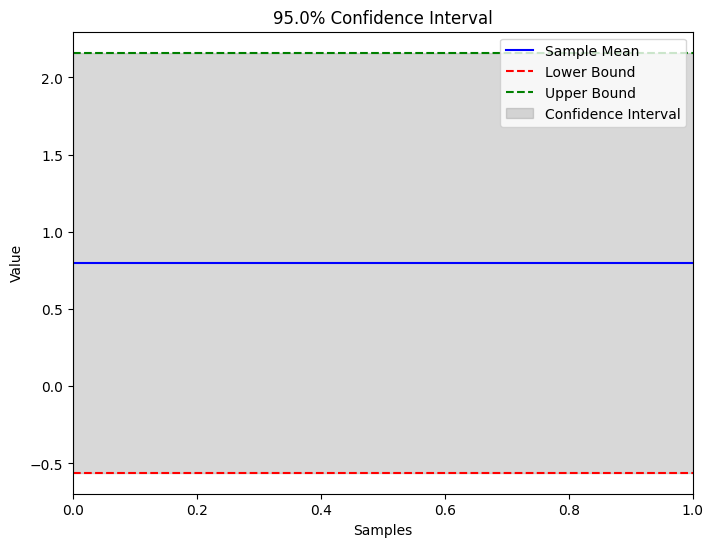

In [15]:
visualize_confidence_interval(scores)

In [16]:
#| hide
import nbdev; nbdev.nbdev_export()